# DI 725 - Project Phase 2

In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-lecd4xp4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-lecd4xp4
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.9 MB/s eta 0:00:00
  Created wheel for clip: filena

In [2]:
import numpy as np
import pandas as pd
import kagglehub
import torch
from transformers import PaliGemmaForConditionalGeneration, PaliGemmaProcessor
import io
import requests
import numpy as np
import PIL
from pathlib import Path
!pip install -q sentence-transformers
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
import clip
from PIL import Image
import matplotlib.pyplot as plt
import random

2025-05-14 06:51:06.938137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747205467.162745      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747205467.233178      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import wandb
wandb.login(key="0e48c15605abf65402208cd05becaa061bf0dfbf")

wandb.init(
    project="vlm_for_image_captioning",
    name="phase2",
    config={
        "max_tokens": 100,
        "temperature": 0.8,
        "top_p": 0.9,
        "peft_strategy": "adapter",
        "batch_size": 4
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: esrasekerci (esrasekerci-metu-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250514_065128-wdbncpwh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run phase2
wandb: ⭐️ View project at https://wandb.ai/esrasekerci-metu-middle-east-technical-university/vlm_for_image_captioning
wandb: 🚀 View run at https://wandb.ai/esrasekerci-metu-middle-east-

In [4]:
data_dir = Path("/kaggle/input/di725-dataset")
image_dir = data_dir / "resized"
caption_file = data_dir / "captions.csv"

model_path = "/kaggle/input/paligemma-2/transformers/paligemma2-3b-pt-224/1"
output_csv_path = "/kaggle/working/generated_captions.csv"

You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
df = pd.read_csv(caption_file)
df.head()

,source,split,image,caption_1,caption_2,caption_3,caption_4,caption_5
0,NWPU,test,NWPU_31430.jpg,A gray plane on the runway and the lawn beside .,A grey plane is on the runway by the lawn .,There is an airplane on the runway with a larg...,A plane is parked on the runway next to the gr...,There is a plane on the runway beside the grass .
1,NWPU,test,NWPU_31431.jpg,Three small planes parked in a line on the air...,"There are four aircraft on the open ground, Th...",There are many planes of different sizes in a ...,Four planes are parked on the runway .,Four planes of different sizes were on the mar...
2,NWPU,test,NWPU_31432.jpg,A plane parked in a line on the airport with s...,A white plane was parked on the instruction li...,An airplane parked in an open area with many c...,A plane is parked on the open space .,There is 1 plane on the ground marked .
3,NWPU,test,NWPU_31433.jpg,A small plane and a big plane parked next to b...,A white plane and a gray plane parked at the b...,Two planes of different sizes are neatly parke...,A large plane and a small plane are parked nea...,Two planes are on the marked ground .
4,NWPU,test,NWPU_31434.jpg,Two planes parked next to boarding bridges .,Two aircraft were parked at the departure gates .,Two planes of different sizes are neatly parke...,Two planes are parked next to the terminal .,Two planes are on the marked ground .


In [6]:
clip_model, preprocess = clip.load("ViT-B/32")

def clip_best_caption(image_path, captions):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to("cuda")
    text = clip.tokenize(captions).to("cuda")

    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text)
        sims = (image_features @ text_features.T).squeeze()

    return captions[sims.argmax().item()]

100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 32.3MiB/s]


In [7]:
results = []

for idx, row in df.head(10).iterrows():
    img_path = image_dir / row['image']
    captions = [row[f"caption_{i}"] for i in range(1, 6)]
    best_caption = clip_best_caption(str(img_path), captions)
    
    results.append({
        "image": row['image'],
        "best_caption": best_caption
    })

best_df = pd.DataFrame(results)
best_df.head()

,image,best_caption
0,NWPU_31430.jpg,There is an airplane on the runway with a larg...
1,NWPU_31431.jpg,"There are four aircraft on the open ground, Th..."
2,NWPU_31432.jpg,There is 1 plane on the ground marked .
3,NWPU_31433.jpg,Two planes are on the marked ground .
4,NWPU_31434.jpg,Two planes are on the marked ground .


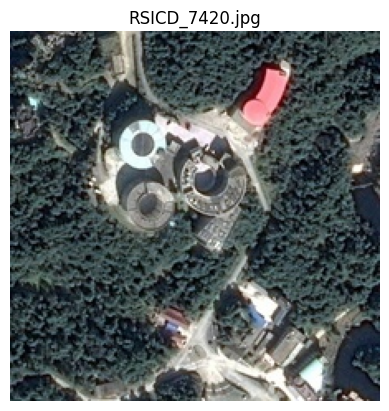

Human-written Captions:
  1. many green trees and several buildings are in a resort .
  2. many green trees and several buildings are in a resort .
  3. many green trees and several buildings are in a resort .
  4. many green trees and several buildings are in a resort .
  5. many green trees and several buildings are in a resort .

CLIP-selected Best Caption:
  many green trees and several buildings are in a resort .

----------------------------------------------------------------------------------------------------


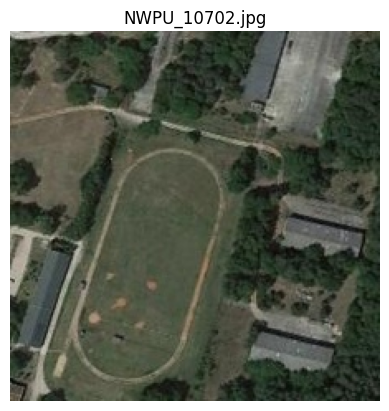

Human-written Captions:
  1. The ground track field is surrounded by some trees and buildings .
  2. There are green fields and red tracks .
  3. The track and field is built on the lawn, Surrounded by many buildings and trees .
  4. There are many trees near the ground track field .
  5. There are some trees and buildings beside the ground track field with a sandy track .

CLIP-selected Best Caption:
  There are some trees and buildings beside the ground track field with a sandy track .

----------------------------------------------------------------------------------------------------


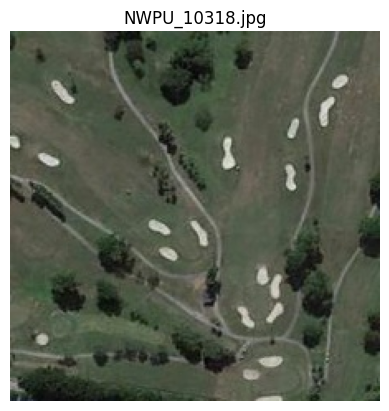

Human-written Captions:
  1. The golf course has some fairways, Roads, Barrier trees and sandpits .
  2. There are about a dozen bunkers on this lawn .
  3. There are a few bunkers and a few paths on the large green lawn on the golf course and many trees .
  4. Several roads intersect on the golf course .
  5. There are many bunkers and some trees on the golf course .

CLIP-selected Best Caption:
  Several roads intersect on the golf course .

----------------------------------------------------------------------------------------------------


In [8]:
sampled_rows = df.sample(n=3)

for _, row in sampled_rows.iterrows():
    img_path = image_dir / row['image']
    captions = [row[f"caption_{i}"] for i in range(1, 6)]
    best_caption = clip_best_caption(str(img_path), captions)

    # Display image
    image = Image.open(img_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(row['image'])
    plt.show()

    # Display all captions
    print("Human-written Captions:")
    for i, cap in enumerate(captions, 1):
        print(f"  {i}. {cap}")

    # Highlight best
    print(f"\nCLIP-selected Best Caption:\n  {best_caption}\n")
    print("-" * 100)

In [9]:
def select_longest_caption(row):
    captions = [row[f"caption_{i}"] for i in range(1, 6)]
    longest = max(captions, key=lambda x: len(x.split()))
    return longest

df["caption"] = df.apply(select_longest_caption, axis=1)

In [10]:
df.head()

,source,split,image,caption_1,caption_2,caption_3,caption_4,caption_5,caption
0,NWPU,test,NWPU_31430.jpg,A gray plane on the runway and the lawn beside .,A grey plane is on the runway by the lawn .,There is an airplane on the runway with a larg...,A plane is parked on the runway next to the gr...,There is a plane on the runway beside the grass .,There is an airplane on the runway with a larg...
1,NWPU,test,NWPU_31431.jpg,Three small planes parked in a line on the air...,"There are four aircraft on the open ground, Th...",There are many planes of different sizes in a ...,Four planes are parked on the runway .,Four planes of different sizes were on the mar...,"There are four aircraft on the open ground, Th..."
2,NWPU,test,NWPU_31432.jpg,A plane parked in a line on the airport with s...,A white plane was parked on the instruction li...,An airplane parked in an open area with many c...,A plane is parked on the open space .,There is 1 plane on the ground marked .,An airplane parked in an open area with many c...
3,NWPU,test,NWPU_31433.jpg,A small plane and a big plane parked next to b...,A white plane and a gray plane parked at the b...,Two planes of different sizes are neatly parke...,A large plane and a small plane are parked nea...,Two planes are on the marked ground .,A white plane and a gray plane parked at the b...
4,NWPU,test,NWPU_31434.jpg,Two planes parked next to boarding bridges .,Two aircraft were parked at the departure gates .,Two planes of different sizes are neatly parke...,Two planes are parked next to the terminal .,Two planes are on the marked ground .,Two planes of different sizes are neatly parke...


In [11]:
split_counts = df["split"].value_counts()
split_percent = df["split"].value_counts(normalize=True) * 100

split_info = pd.DataFrame({
    "Count": split_counts,
    "Percentage": split_percent.round(2)
})

print(split_info)

       Count  Percentage
split                   
train  35614       79.99
test    4454       10.00
val     4453       10.00


# Downloading Paligemma Weights

Here we will be downloading the paligemma weights available in the kagglehub.

Transformers PaliGemma 2 3B weights, pre-trained with 224*224 input images and 128 token input/output text sequences. The models are available in bfloat16 for fine-tuning.

In [12]:
from transformers import AutoProcessor, AutoModelForVision2Seq
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_path)
model = AutoModelForVision2Seq.from_pretrained(model_path, torch_dtype=torch.float16).to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

NOTE: PaliGemma 2 checkpoints are intended for use as a base for fine-tuning to your specific use cases.

We will assume that your fine-tuned model is available in your environment at the location indicated by path.

First, import Transformers and set up the model and processor.

In [13]:
def read_image(path):
    image = Image.open(path).convert("RGB")
    image = np.array(image)
    if image.shape[-1] == 4:
        image = image[:, :, :3]
    return image

In [14]:
def generate_caption_from_array(image_array, prompt="<image> describe this image in detail", max_tokens=50):
    inputs = processor(
        text=prompt,
        images=image_array,
        padding="longest",
        do_convert_rgb=True,
        return_tensors="pt"
    ).to(device)

    inputs = inputs.to(dtype=model.dtype)

    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=max_tokens)

    return processor.decode(output[0], skip_special_tokens=True)

In [15]:
def run_inference(
    df_subset: pd.DataFrame,
    image_dir: Path,
    output_csv_path: str,
    prompt: str = "<image> describe this image in detail",
    max_tokens: int = 50,
):
    """Generate captions for every row in df_subset, save to CSV, return DataFrame."""
    results = []
    df_subset = df_subset.reset_index(drop=True)

    for idx in tqdm(range(len(df_subset)), desc="Generating captions"):
        row = df_subset.iloc[idx]
        img_path = image_dir / row["image"]
        if not img_path.exists():
            tqdm.write(f"Missing image: {img_path.name}")
            continue

        image_array = read_image(img_path)
        generated = generate_caption_from_array(
            image_array, prompt=prompt, max_tokens=max_tokens
        )
        results.append({
            "image": row["image"],
            "generated_caption": generated,
            "reference_caption": row["caption"],
        })

    df_out = pd.DataFrame(results)
    df_out.to_csv(output_csv_path, index=False)
    return df_out

In [16]:
train_df = df[df["split"] == "train"]

#train_preds = run_inference(
#    train_df,
#    image_dir,
#    output_csv_path="/kaggle/working/train_preds.csv",
#    prompt="<image> describe this image in detail",
#    max_tokens=40
#)

In [17]:
val_df = df[df["split"] == "val"]

In [18]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [19]:
pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
from evaluate import load as hf_load

In [21]:
bleu_metric    = hf_load("bleu")     # wraps sacrebleu
meteor_metric  = hf_load("meteor")
bertscore_metric = hf_load("bertscore")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [22]:
def evaluate_metrics(df: pd.DataFrame, prompt: str, max_tokens: int):
    """
    df must have columns ['generated_caption','reference_caption'].
    Returns dict with BLEU/METEOR/BERTScore_F1 plus prompt & max_tokens.
    """
    hyps = df["generated_caption"].tolist()
    # evaluate.load("bleu") expects references as List[List[str]]
    refs = [[r] for r in df["reference_caption"].tolist()]

    # 1) BLEU
    bleu_res = bleu_metric.compute(predictions=hyps, references=refs)
    bleu_score = float(bleu_res["bleu"])

    # 2) METEOR
    meteor_res = meteor_metric.compute(predictions=hyps, references=refs)
    meteor_score = float(meteor_res["meteor"])

    # 3) BERTScore
    bert_res = bertscore_metric.compute(
        predictions=hyps,
        references=df["reference_caption"].tolist(),
        lang="en",
        rescale_with_baseline=True,
    )
    bert_f1 = float(np.mean(bert_res["f1"]))

    return {
        "prompt": prompt,
        "max_tokens": max_tokens,
        "BLEU": bleu_score,
        "METEOR": meteor_score,
        "BERTScore_F1": bert_f1,
    }

In [23]:
wandb.init(
    project="vlm_for_image_captioning",
    name="val_prompt_sweep",
    config={
        "model": "paligemma-2-3b",
        "task": "val_prompt_tuning",
    }
)
import os
os.makedirs("/kaggle/working", exist_ok=True)

prompt_list     = [
    "<image> provide a detailed satellite description of this scene.",
    "<image> describe the visible objects and their arrangement from above.",
    "<image> explain the layout of the terrain and infrastructure."
]
max_tokens_list = [30, 50]

sweep_results = []

for prompt in prompt_list:
    # sanitize prompt for filenames
    safe_name = prompt[:30].replace(" ", "_").replace("/", "_")
    for max_tokens in max_tokens_list:
        # output filename per run
        out_csv = f"/kaggle/working/val_preds_{safe_name}_tok{max_tokens}.csv"

        # (1) generate captions
        df_preds = run_inference(
            val_df,
            image_dir,
            output_csv_path=out_csv,
            prompt=prompt,
            max_tokens=max_tokens,
        )

        # (2) compute & log metrics
        metrics = evaluate_metrics(df_preds, prompt, max_tokens)
        wandb.log(metrics)          # this will produce BLEU/METEOR/BERTScore plots
        sweep_results.append(metrics)

wandb: uploading summary, console lines 40-173
wandb:                                                                                
wandb: 🚀 View run phase2 at: https://wandb.ai/esrasekerci-metu-middle-east-technical-university/vlm_for_image_captioning/runs/wdbncpwh
wandb: ⭐️ View project at: https://wandb.ai/esrasekerci-metu-middle-east-technical-university/vlm_for_image_captioning
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_065128-wdbncpwh/logs
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250514_065242-5rh9upj1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run val_prompt_sweep
wandb: ⭐️ View project at https://wandb.ai/esrasekerci-metu-middle-east-technical-university/vlm_for_image_captioning
wandb: 🚀 View run at https://wandb.ai/esrasekerci-metu-middle-east-technical-university/vlm_for_image_captioning/runs/5rh9upj1
Ge

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating captions: 100%|██████████| 4453/4453 [35:37<00:00,  2.08it/s]


In [24]:
sweep_df = (
    pd.DataFrame(sweep_results)
      .sort_values(by="BERTScore_F1", ascending=False)
      .reset_index(drop=True)
)
summary_csv = "/kaggle/working/val_sweep_summary.csv"
sweep_df.to_csv(summary_csv, index=False)

wandb.log({
    "val_sweep_summary": wandb.Table(dataframe=sweep_df)
})

wandb.finish()

wandb: uploading artifact run-5rh9upj1-val_sweep_summary; uploading output.log; uploading config.yaml
wandb: uploading history steps 5-6, summary
wandb:                                                                                
wandb: 
wandb: Run history:
wandb: BERTScore_F1 ▁▁▃▃██
wandb:         BLEU ▁▁▁▁██
wandb:       METEOR ▁▁▄▄██
wandb:   max_tokens ▁█▁█▁█
wandb: 
wandb: Run summary:
wandb: BERTScore_F1 0.12102
wandb:         BLEU 0.00411
wandb:       METEOR 0.12778
wandb:   max_tokens 50
wandb:       prompt <image> explain the ...
wandb: 
wandb: 🚀 View run val_prompt_sweep at: https://wandb.ai/esrasekerci-metu-middle-east-technical-university/vlm_for_image_captioning/runs/5rh9upj1
wandb: ⭐️ View project at: https://wandb.ai/esrasekerci-metu-middle-east-technical-university/vlm_for_image_captioning
wandb: Synced 5 W&B file(s), 1 media file(s), 2 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250514_065242-5rh9upj1/logs


In [25]:
best_row         = sweep_df.loc[sweep_df["BERTScore_F1"].idxmax()]
best_prompt      = best_row["prompt"]
best_max_tokens  = int(best_row["max_tokens"])

print("Best prompt:", best_prompt)
print("Best max_tokens:", best_max_tokens)

import json
with open("/kaggle/working/best_val_config.json", "w") as f:
    json.dump({"prompt": best_prompt, "max_tokens": best_max_tokens}, f)

Best prompt: <image> explain the layout of the terrain and infrastructure.
Best max_tokens: 30


In [26]:
best_prompt = "<image> explain the layout of the terrain and infrastructure."
best_max_tokens = 30

In [27]:
train_out_csv = "/kaggle/working/train_preds_best.csv"
df_train_preds = run_inference(
    df_subset       = train_df,
    image_dir       = image_dir,
    output_csv_path = train_out_csv,
    prompt          = best_prompt,
    max_tokens      = best_max_tokens
)

train_metrics = evaluate_metrics(df_train_preds, best_prompt, best_max_tokens)
print("TRAIN metrics (new):", train_metrics)

wandb.init(
    project="vlm_for_image_captioning",
    name="train_evaluation",
    config={"prompt": best_prompt, "max_tokens": best_max_tokens},
    resume="allow",
)
wandb.log(train_metrics)
wandb.save(train_out_csv)
wandb.finish()

Generating captions: 100%|██████████| 35614/35614 [4:50:08<00:00,  2.05it/s]


TRAIN metrics (new): {'prompt': '<image> explain the layout of the terrain and infrastructure.', 'max_tokens': 30, 'BLEU': 0.0038282745502463793, 'METEOR': 0.12505818524156403, 'BERTScore_F1': 0.12115904373100997}


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250514_145538-noqufytc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train_evaluation
wandb: ⭐️ View project at https://wandb.ai/esrasekerci-metu-middle-east-technical-university/vlm_for_image_captioning
wandb: 🚀 View run at https://wandb.ai/esrasekerci-metu-middle-east-technical-university/vlm_for_image_captioning/runs/noqufytc
wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: uploading working/train_preds_best.csv; uploading config.yaml
wandb: uploading working/train_preds_best.csv
wandb:                                                                                
wandb: 
wandb: Run history:
wandb: BERTScore_F1 ▁
wandb:         BLEU ▁
wandb:       METEOR ▁
wandb:   max_tokens ▁
wandb: 
wandb: Run summary:
wandb: BERTScore_F1 0

In [28]:
test_df = df[df["split"] == "test"].reset_index(drop=True)
test_out_csv = "/kaggle/working/test_preds.csv"
df_test_preds = run_inference(
    df_subset       = test_df,
    image_dir       = image_dir,
    output_csv_path = test_out_csv,
    prompt          = best_prompt,
    max_tokens      = best_max_tokens
)

test_metrics = evaluate_metrics(df_test_preds, best_prompt, best_max_tokens)
print("TEST metrics:", test_metrics)

pd.DataFrame([test_metrics]).to_csv("/kaggle/working/test_summary.csv", index=False)

wandb.init(
    project="vlm_for_image_captioning",
    name="test_evaluation",
    config={"prompt": best_prompt, "max_tokens": best_max_tokens}
)
wandb.log(test_metrics)
wandb.save(test_out_csv)
wandb.save("/kaggle/working/test_summary.csv")
wandb.finish()

Generating captions: 100%|██████████| 4454/4454 [36:29<00:00,  2.03it/s]


TEST metrics: {'prompt': '<image> explain the layout of the terrain and infrastructure.', 'max_tokens': 30, 'BLEU': 0.003996523372485927, 'METEOR': 0.12691534451344166, 'BERTScore_F1': 0.12238152035710889}


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250514_153230-mbxvvofo
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run test_evaluation
wandb: ⭐️ View project at https://wandb.ai/esrasekerci-metu-middle-east-technical-university/vlm_for_image_captioning
wandb: 🚀 View run at https://wandb.ai/esrasekerci-metu-middle-east-technical-university/vlm_for_image_captioning/runs/mbxvvofo
wandb: uploading working/test_preds.csv; uploading config.yaml
wandb: uploading working/test_preds.csv
wandb:                                                                                
wandb: 
wandb: Run history:
wandb: BERTScore_F1 ▁
wandb:         BLEU ▁
wandb:       METEOR ▁
wandb:   max_tokens ▁
wandb: 
wandb: Run summary:
wandb: BERTScore_F1 0.12238
wandb:         BLEU 0.004
wandb:       METEOR 0.12692
wandb:   max_tokens 30
wandb:       prompt <image> explain the ...
wandb: 
wandb: 🚀 View run test_evaluation at: https://wa